In [3]:
import numpy as np
import pandas as pd
import scipy 
import numpy.matlib
import nilearn
import random
import matplotlib.pyplot as plt
import seaborn as sns
import glob
# import matplotlib_inline
import matplotlib
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
import datetime

In [2]:
# motor and value areas functional connectivity matrix
task_fc = pd.read_csv('task_fc_motor_value.csv', index_col = 'Subject')

In [24]:
# read trial by trial data and merge into one dataframe
data_dir = r'./trial_data/'
behavioral_files = glob.glob(data_dir+'*')
behavioral_results = [pd.read_excel(behavioral_files[i]) for i in range(len(behavioral_files))]
behavioral_results = pd.concat(behavioral_results)

In [25]:
behavioral_results[behavioral_results['SID']==101]

,SID,obs,block,slope,IntersectionY,X_allocation,Y_allocation,RT,Remaining_time,ITI,...,PC1_group4,PC2_group4,PC1_group1.1,PC2_group1.1,PC1_group2.1,PC2_group2.1,PC1_group3.1,PC2_group3.1,PC1_group4.1,PC2_group4.1
0,101,1,1,-0.592929,49.719476,70.9,7.7,4.062661,6.937339,6.157613,...,-0.190801,1.539433,1.547450,-0.273457,1.067076,-1.396046,0.427941,-0.038159,0.045936,-0.714124
1,101,2,1,-0.245768,19.678900,65.9,3.5,5.280050,5.719950,6.632359,...,0.527950,0.419579,-1.132474,0.251435,1.068491,-0.460882,0.168117,-0.083255,-0.429363,0.684519
2,101,3,1,-0.625716,37.926091,30.8,18.6,5.803318,5.196682,5.086624,...,1.666453,0.496879,-0.480824,-0.537151,0.135216,0.782448,-0.172619,0.160090,-0.193044,-0.311160
3,101,4,1,-0.744867,55.012215,68.2,4.2,5.078642,5.921358,5.453118,...,-0.419451,-0.333518,1.019731,-0.292663,1.183672,-0.483584,0.469275,0.056372,-0.131421,-0.345082
4,101,5,1,-3.648559,70.372307,0.7,68.0,5.708948,5.291052,5.094208,...,0.364645,-0.465768,0.209460,0.370985,-0.516305,0.459787,-0.320709,-0.194313,1.981715,-0.201773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,101,71,3,-0.612983,44.784628,55.8,10.6,4.065171,6.934829,5.086624,...,-0.875159,-1.528327,0.007089,-0.015450,0.654198,-0.470381,-0.005208,-0.174739,-0.630452,-0.417753
71,101,72,3,-0.190965,18.362615,96.2,0.0,5.040610,5.959390,6.126987,...,-0.251254,0.214920,-0.870307,0.518705,0.367530,0.242607,0.802678,-0.053750,-2.599713,-0.374145
72,101,73,3,-0.662162,46.526453,47.2,15.2,5.626290,5.373710,5.084264,...,0.928727,0.469469,-0.094499,-0.039893,0.483987,0.551875,0.138854,0.200241,-0.340429,0.842810
73,101,74,3,-1.161074,99.625063,38.7,54.7,6.913913,4.086087,5.066007,...,-0.500550,-1.497367,-0.273081,0.358323,0.772903,0.736265,0.453149,-0.057968,0.034487,1.493258


In [ ]:
X = task_fc
# choose only subjects that did a resting scan
Ys = behavioral_results.loc[task_fc.index]
# shorten names of variables
Ys = Ys.rename({'AFRIAT Index' : 'Afriat Index', 'VARIAN Index AVG(SSQ)' : 'Varian Index', 'MMI Criterion Avg(SumOfSquares(Wastes))' : 'MMI'}, axis = 1)
all_measures = ['GARP Violations', 'Afriat Index', 'Varian Index', 'Houtman Maks Index', 'MMI']

In [ ]:
# write data for R model
len(Ys)

43

In [ ]:
# remove perfectly-consistent subjects
inconsistent_subjects = Ys.loc[:, 'GARP Violations']!=0
Ys_incon = Ys.loc[inconsistent_subjects, :]
X_incon = X.loc[inconsistent_subjects, :]

In [ ]:
Ys_incon.shape

(35, 14)

<AxesSubplot:>

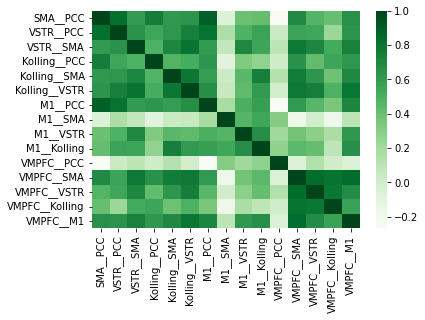

In [ ]:
sns.heatmap(X.corr(), cmap='Greens')

In [ ]:
# Y's correlation matrix
Ys_incon.loc[:, all_measures].corr()

,GARP Violations,Afriat Index,Varian Index,Houtman Maks Index,MMI
GARP Violations,1.000000,0.926514,0.972788,0.893275,0.795288
Afriat Index,0.926514,1.000000,0.982546,0.903812,0.837014
Varian Index,0.972788,0.982546,1.000000,0.916406,0.818154
Houtman Maks Index,0.893275,0.903812,0.916406,1.000000,0.886821
MMI,0.795288,0.837014,0.818154,0.886821,1.000000
